In [267]:
#Загрузка библиотек:
!pip install category_encoders
!pip install xgboost
!pip install keras
!pip install tensorFlow as tf
!pip install sklearn

import warnings 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
import matplotlib
import datetime 

from keras.models import Sequential
from keras.layers import Activation, Dense
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, SGDRegressor, ElasticNet
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
warnings.filterwarnings("ignore")

ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


In [268]:
#1.Загрузка датасета cars.csv:
data = pd.read_csv('cars.csv', encoding="cp1251")
data.drop(columns = ['dateCrawled', 'dateCreated','lastSeen;;;;;;;;', 'postalCode'], inplace = True)
data.dropna(how = 'all', inplace = True)
data.drop_duplicates(inplace = True)

In [269]:
#2.Сделайте описательную статистику: размер, типы переменных, пустые значения, уникальные имена и т.д.
print("1. Количество строк:", data.shape[0], ", количество столбцов:", data.shape[1], "\n")

print("2. Типы переменных:")
print(data.dtypes, "\n")

print("3. Сумма пустых значений по столбцам:")
print(data[data.columns].apply(lambda x: x.isna().sum()), "\n")

print("4. Сумма уникальных значений по столбцам:")
print(data[data.columns].apply(lambda x: x.dropna().nunique()), "\n")

1. Количество строк: 365898 , количество столбцов: 16 

2. Типы переменных:
name                    object
seller                  object
offerType               object
price                   object
abtest                  object
vehicleType             object
yearOfRegistration      object
gearbox                 object
powerPS                 object
model                   object
kilometer              float64
monthOfRegistration     object
fuelType                object
brand                   object
notRepairedDamage       object
nrOfPictures           float64
dtype: object 

3. Сумма пустых значений по столбцам:
name                       0
seller                     0
offerType                  0
price                      0
abtest                     1
vehicleType            37605
yearOfRegistration         2
gearbox                19650
powerPS                    0
model                  20375
kilometer                  0
monthOfRegistration        1
fuelType               331

In [270]:
#3) Работа с типами переменных:
print("Преобразованные типы переменных:")

strcolumns = ['name', 'seller', 'offerType', 'abtest', 'vehicleType', 'gearbox', 'model', 
              'fuelType', 'brand', 'notRepairedDamage']
new_type1 = {k: 'string' for k in strcolumns}
data = data.astype(new_type1)

numcolumns = ['kilometer', 'nrOfPictures', 'price', 'yearOfRegistration', 'powerPS','monthOfRegistration']
data[numcolumns] = data[numcolumns].apply(pd.to_numeric, errors='coerce')
new_type2 = {k: 'Int64' for k in numcolumns}
data = data.astype(new_type2)

print(data.dtypes)

Преобразованные типы переменных:
name                   string
seller                 string
offerType              string
price                   Int64
abtest                 string
vehicleType            string
yearOfRegistration      Int64
gearbox                string
powerPS                 Int64
model                  string
kilometer               Int64
monthOfRegistration     Int64
fuelType               string
brand                  string
notRepairedDamage      string
nrOfPictures            Int64
dtype: object


In [271]:
#4) Работа с пропусками:
data = data[data['brand'].notna()]
data = data[data['price'] != 0]
data.dropna(subset=['price'], inplace=True)
data = data.drop(['notRepairedDamage', 'nrOfPictures', 'name'], axis = 1) #слишком много пропусков в первом столбце, 
                                                                          #нулей во втором и
                                                                          #уникальных значений в третьем
strcolumns.remove('notRepairedDamage')
strcolumns.remove('name')
numcolumns.remove('nrOfPictures')
data[['powerPS', 'yearOfRegistration', 'monthOfRegistration']] = data[['powerPS', 
    'yearOfRegistration', 'monthOfRegistration']].replace(0, np.nan) #не могут равняться 0 по смыслу 

for brand in data.brand.unique():
    data.model.fillna(data[data['brand'] == brand].model.mode()[0], inplace=True) #заполнение столбца с моделями

scolumns = strcolumns.copy()
scolumns.remove('brand')
scolumns.remove('model')
for col in scolumns:
    for model in data.model.unique():
        data[col].fillna(data[data['model'] == model][col].mode()[0], inplace=True) #заполнение текстовых столбцов
        
for col in numcolumns:
    for model in data.model.unique():
        data[col].fillna(np.round(data[data['model'] == model][col].mean()), inplace=True) #заполнение числовых столбцов

print("Сумма пустых значений по столбцам после присвоения моды пустым значениям категориальным столбцам", 
      "\n", "и среднего значения по числовым столбцам c учётом модели в записи:") 
print(data[data.columns].apply(lambda x: x.isna().sum()))

data = data[(data['monthOfRegistration'] >=1) & (data['monthOfRegistration'] <=12)]
data = data.query('gearbox == "manuell" | gearbox == "automatik"') #фильтрация по смыслу

numcolumns.remove('price') #целевой столбец

Сумма пустых значений по столбцам после присвоения моды пустым значениям категориальным столбцам 
 и среднего значения по числовым столбцам c учётом модели в записи:
seller                 0
offerType              0
price                  0
abtest                 0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
dtype: int64


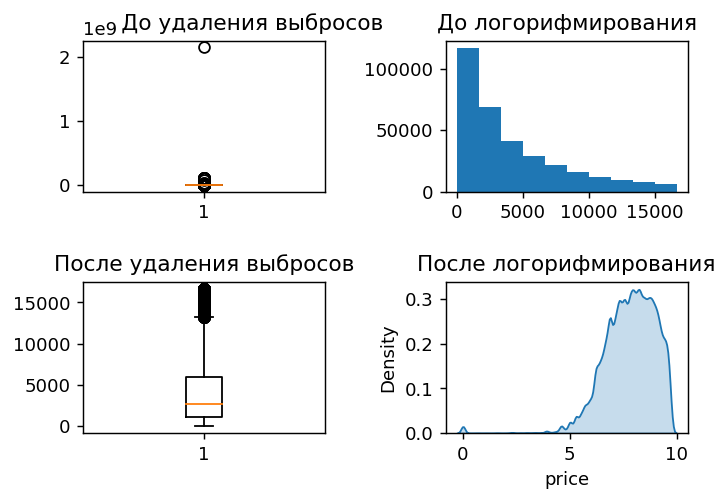

In [272]:
#5) Работа со столбцом "Price":
fig, ax = plt.subplots(2,2)
fig.set_dpi(130)
plt.subplots_adjust(wspace=0.5, hspace=0.6)

ax[0,0].boxplot(data['price'])
ax[0,0].set(title = "              До удаления выбросов")

Q1, Q3 = data['price'].quantile(0.25), data['price'].quantile(0.75)
IQR = Q3- Q1
lower_bound, upper_bound = Q1 - (1.5 * IQR), Q3 + (1.5 * IQR) 
data = data[(data['price'] > lower_bound) & (data['price'] < upper_bound)]

ax[1,0].boxplot(data['price'])
ax[1,0].set(title = "После удаления выбросов")
ax[0,1].hist(data['price'], bins = 10)
ax[0,1].set(title = "До логорифмирования")

sns.kdeplot(np.log(data.price), shade=True)
plt.title('После логорифмирования')
plt.show()

Ящиковые диаграммы зависимости:


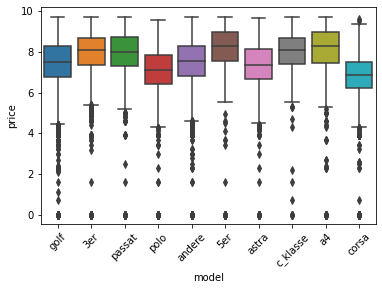

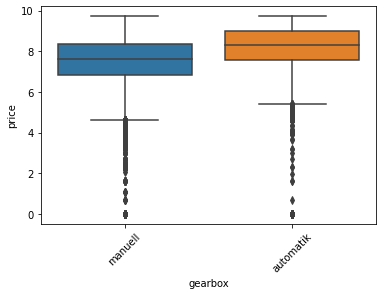

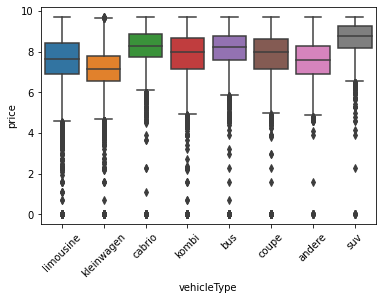

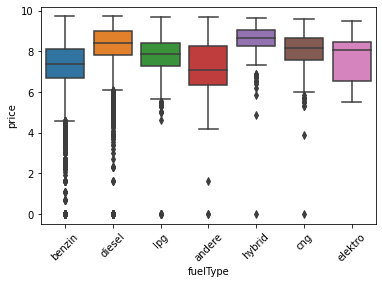

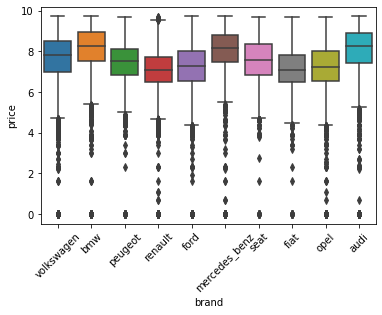

In [273]:
#6) Ящиковые диаграммы зависимости:
print('Ящиковые диаграммы зависимости:')

for col in numcolumns:
    Q1, Q3 = data[col].quantile(0.25), data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - (1.5 * IQR), Q3 + (1.5 * IQR) 
    data = data[(data[col] > lower_bound) & (data[col] < upper_bound)]

for column in ['model', 'gearbox', 'vehicleType', 'fuelType', 'brand']:
    columne_most_freq = data[column].value_counts()[:10].sort_values(ascending=False).index
    ax = sns.boxplot(
    x=data[data[column].isin(columne_most_freq)][column], 
    y=np.log(data[data[column].isin(columne_most_freq)].price))
    plt.xticks(rotation=45)
    plt.show()

In [274]:
#7) Алгоритмы для работы с категориальными данными:

#1.
data_enc = data.copy()
le = LabelEncoder()
for i in strcolumns:
    data_enc[i] = le.fit_transform(data_enc[i]) #для корреляционного анализа

#2.
#data[strcolumns] = data[strcolumns].astype('str')
#onehotencoder = OneHotEncoder(sparse=False)
#for i in strcolumns:
#    data[i] = onehotencoder.fit_transform(data[i].values.reshape(-1, 1))
#    dict_name = dict(zip(le.classes_, le.transform(le.classes_))) #не эффективно

#3.
#data_conf = data
#data_conf = pd.get_dummies(data_conf, columns = strcolumns) #используется поcле корреляционного анализа

Диаграмма корреляций:


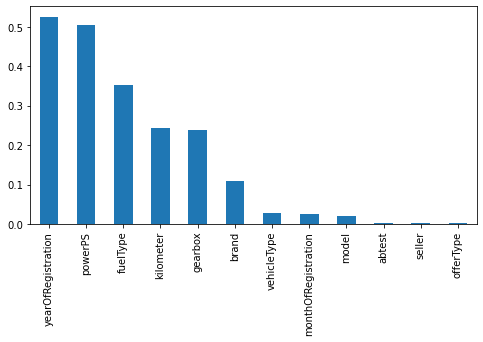

In [275]:
#8) Матрица корреляций:
print('Диаграмма корреляций:')
plt.figure(figsize=(8, 4))
abs(data_enc.corr()['price']).sort_values(ascending = False)[1:].plot(kind = 'bar')

data.drop(['abtest', 'seller', 'offerType'], axis = 1, inplace=True) #маленькое влияние при корреляционном анализе

strcolumns, numcolumns = [], []
for i in data.columns:
    if str(data[i].dtypes) == "string":
        strcolumns.append(i)
    elif i != 'price':
        numcolumns.append(i)
        
data_conf = data.copy()
data_conf = pd.get_dummies(data_conf, columns = strcolumns)

In [276]:
#9) Нормализация количественных величин:
scaler = MinMaxScaler()
data_conf[numcolumns] = scaler.fit_transform(data_conf[numcolumns])

In [277]:
#10) Вывод конечного датасета:
print('Вывод конечного датасета:')
data_conf

Вывод конечного датасета:


,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,vehicleType_andere,vehicleType_bus,vehicleType_cabrio,vehicleType_coupe,vehicleType_kleinwagen,...,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
0,480,0.148148,0.524229,1.000000,0.454545,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,0.444444,0.325991,1.000000,0.454545,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,3600,0.703704,0.299559,0.000000,0.545455,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
5,650,0.222222,0.444934,1.000000,0.818182,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2200,0.555556,0.475771,1.000000,0.636364,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371816,3200,0.555556,0.986784,1.000000,0.363636,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
371817,1150,0.407407,0.524229,1.000000,0.181818,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
371820,1199,0.407407,0.440529,0.583333,0.181818,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
371821,9200,0.259259,0.444934,1.000000,0.181818,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [278]:
#11) Модели линейной регрессии:
xtrain, xtest, ytrain, ytest = train_test_split(data_conf.drop(['price'], axis = 1), 
                                                data_conf['price'],test_size=0.2, random_state = 1)

elast = ElasticNet(random_state = 1)
elast.fit(xtrain, ytrain)

lasso = Lasso(random_state = 1)
lasso.fit(xtrain, ytrain)

ridge = Ridge(random_state = 1)
ridge.fit(xtrain, ytrain)

Ridge(random_state=1)

In [279]:
#12) Случайный лес:
bag = RandomForestRegressor(n_estimators=50, random_state=1)
bag.fit(xtrain, ytrain)

RandomForestRegressor(n_estimators=50, random_state=1)

In [280]:
#13) Градиентный пуск:
gdr = GradientBoostingRegressor(n_estimators = 100, learning_rate = 0.2)
gdr.fit(xtrain, ytrain)

GradientBoostingRegressor(learning_rate=0.2)

In [281]:
#14) Нейронная сеть:
x_train=np.asarray(xtrain).astype(np.float32)
y_train=np.asarray(ytrain).astype(np.float32)
x_test=np.asarray(xtest).astype(np.float32)
y_test=np.asarray(ytest).astype(np.float32)

neur = Sequential()
neur.add(Dense(30, activation='relu'))
neur.add(Dense(30, activation='relu'))
neur.add(Dense(1, activation='relu'))
neur.compile(loss='mse', optimizer = 'adam', metrics=['accuracy'])

neur.fit(x_train, y_train, epochs = 5, batch_size = 10)

Epoch 1/5
20561/20561 [==============================] - 21s 1ms/step - loss: 5106278.5000 - accuracy: 0.0031
Epoch 2/5
20561/20561 [==============================] - 21s 999us/step - loss: 3342225.5000 - accuracy: 0.0031
Epoch 3/5
20561/20561 [==============================] - 21s 1ms/step - loss: 3183053.5000 - accuracy: 0.0030
Epoch 4/5
20561/20561 [==============================] - 21s 1ms/step - loss: 2981732.7500 - accuracy: 0.0030
Epoch 5/5
20561/20561 [==============================] - 23s 1ms/step - loss: 2771125.0000 - accuracy: 0.0031


In [282]:
#15) Сравнение моделей:
print('Сравнение моделей:')
columns = ['Метод', 'R^2', 'RMSE']
res = pd.DataFrame(columns = columns)

row1 = {'Метод': 'Эластичная регрессия', 'R^2': round(r2_score(ytest, elast.predict(xtest)), 1), 
        'RMSE': round(np.sqrt(MSE(ytest, elast.predict(xtest))), 2)}
row2 = {'Метод': 'Лассо-регрессия', 'R^2': round(r2_score(ytest, lasso.predict(xtest)), 2), 
        'RMSE': round(np.sqrt(MSE(ytest, lasso.predict(xtest))), 2)}
row3 = {'Метод': 'Ридж-регрессия', 'R^2':round(r2_score(ytest, ridge.predict(xtest)), 2), 
        'RMSE': round(np.sqrt(MSE(ytest, ridge.predict(xtest))), 2)}
row4 = {'Метод':'Случайный лес', 'R^2':round(r2_score(ytest, bag.predict(xtest)), 2), 
        'RMSE':round(np.sqrt(MSE(ytest, bag.predict(xtest))), 2)}
row5 = {'Метод':'Градиентный пуск', 'R^2': round(r2_score(y_test, gdr.predict(x_test)), 2), 
        'RMSE': round(np.sqrt(MSE(y_test, gdr.predict(x_test))), 2)}
row6 = {'Метод':'Нейронная сеть', 'R^2':round(r2_score(y_test, neur.predict(x_test)), 2),
       'RMSE': round(np.sqrt(MSE(y_test, neur.predict(x_test))).astype('float64'), 2)}
res = res.append([row1, row2, row3, row4, row5, row6], ignore_index = True).sort_values(by = 'R^2', ascending = False)
res.reset_index(drop=True)

Сравнение моделей:


,Метод,R^2,RMSE
0,Случайный лес,0.84,1332.21
1,Градиентный пуск,0.82,1438.90
2,Нейронная сеть,0.76,1634.42
3,Ридж-регрессия,0.65,1994.04
4,Лассо-регрессия,0.64,2020.02
5,Эластичная регрессия,0.20,2912.82


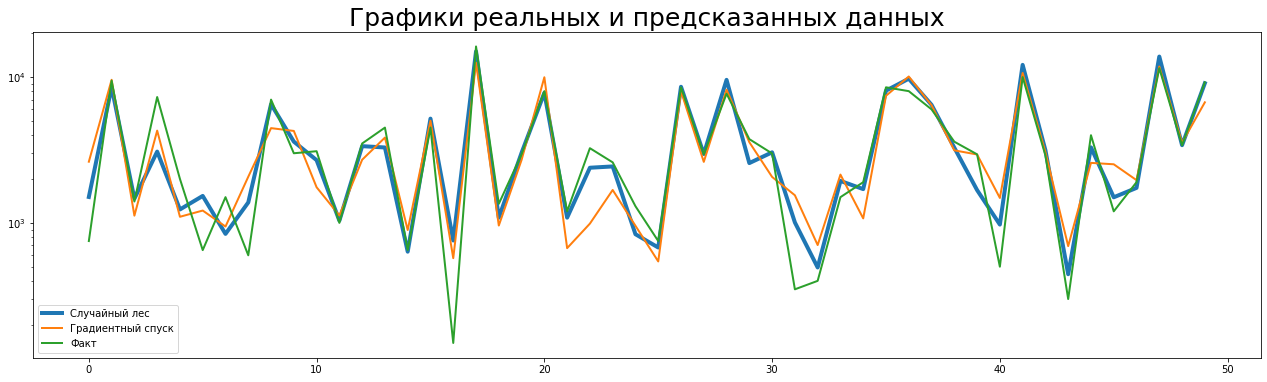

In [283]:
#16) Графики реальных и предсказанных данных:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(22,6))

X = xtest.head(50)
plt.plot(range(50), np.array(bag.predict(X)), label = 'Случайный лес', linewidth=4.0)
plt.plot(range(50), np.array(gdr.predict(X)), label = 'Градиентный спуск', linewidth=2.0)
plt.plot(range(50), np.array(ytest.head(50)), label = 'Факт', linewidth=2.0)

plt.title('Графики реальных и предсказанных данных', fontsize = 25)
plt.yscale('log')
plt.legend()
plt.show()

In [284]:
#Система предсказания цены автомобиля
print('Система предсказания цены автомобиля:', '\n')
data_on = data
marks = {}
for i in (numcolumns + strcolumns): 
    colname = i 
    coloname = i+": "
    ans = input(coloname) 
    marks[colname] = ans

test_on = data_on.append(marks, ignore_index=True)
test_on = pd.get_dummies(test_on, columns = strcolumns)
test_on[numcolumns] = scaler.fit_transform(test_on[numcolumns])
test_one = test_on.iloc[[-1]].drop('price', axis = 1)
test_whole = test_on[:-1]

ywhole = test_whole['price']
xwhole = test_whole.drop('price', axis = 1)
bag = RandomForestRegressor(n_estimators=50, random_state=1)
bag.fit(xwhole, ywhole)
print ('\n','Предсказанная цена: ', bag.predict(test_one).astype(int)[0])

Система предсказания цены автомобиля: 

yearOfRegistration: 2015
powerPS: 115
kilometer: 15000
monthOfRegistration: 6
vehicleType: bus
gearbox: manuell
model: transporter
fuelType: diesel
brand: volkswagen

 Предсказанная цена:  11673
